In [1]:
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
dods = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep"
yyyy = 2019
ds = xr.open_dataset(f"{dods}/slp.{yyyy}.nc")

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'slp' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [58]:
yyyymmdd = f"{yyyy}-10-09"
lat0, lat1 = 60, 0
lon0, lon1 = 110, 170
slp = ds.slp.loc[yyyymmdd, lat0:lat1, lon0:lon1]

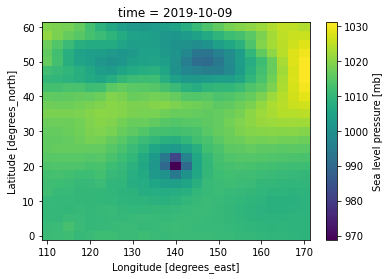

In [59]:
slp.plot()

[pytrack](https://github.com/tenomoto/pytrack)

    # f: one dimensional array storing stencil value
    #    in the following order
    #  y^
    #  1| 7 6 5
    #  0| 8 0 4
    # -1| 1 2 3
    #  ---------->
    #    -1 0 1 x

In [68]:
from scipy import ndimage

loc_min = np.where(ndimage.filters.minimum_filter(slp, size=(3,3), mode=('nearest', 'wrap')) == slp)

In [69]:
hres = 2.5
lon = slp.lon.data
lat = slp.lat.data
lon0, lat0 = 140, 20
dx = np.deg2rad(lon[loc_min[1]] - lon0)
y1 = np.deg2rad(lat[loc_min[0]])
y0 = np.deg2rad(lat0)
d = np.arccos(np.sin(y0) * np.sin(y1) + np.cos(y0) * np.cos(y1) * np.cos(dx))
n = np.argmin(d)
jmin, imin = loc_min[0][n], loc_min[1][n]

In [78]:
f[0] = slp[jmin, imin]
f[1] = slp[jmin-1, imin-1]
f[2] = slp[jmin-1, imin]
f[3] = slp[jmin-1, imin+1]
f[4] = slp[jmin, imin+1]
f[5] = slp[jmin+1, imin+1]
f[6] = slp[jmin+1, imin]
f[7] = slp[jmin+1, imin-1]
f[8] = slp[jmin, imin-1]

In [80]:
c = np.zeros_like(f)
c[0] = f[0]
c[1] = f[4] - f[8]
c[2] = f[6] - f[2]
c[3] = f[1] - f[3] + f[5] - f[7]
c[4] = 2.0 * (f[4] + f[8] - 2.0 * f[0])
c[5] = 2.0 * (f[2] + f[6] - 2.0 * f[0])
c[6] = 2.0 * (f[5] + f[7] - f[1] - f[3] - 2.0 * (f[6] - f[2]))
c[7] = 2.0 * (f[3] + f[5] - f[1] - f[7] - 2.0 * (f[4] - f[8]))
c[8] = 4.0 * (f[1] + f[3] + f[5] + f[7] - 2.0 * (f[2] + f[4] + f[6] + f[8]) + 4.0 * f[0])
fx, fy, fxy = c[1], c[2], c[3]
fxx, fyy = 2.0 * c[4], 2.0 * c[5]
d = fxx * fyy - fxy * fxy

In [91]:
x = ( fyy * (-fx) + (-fxy) * (-fy)) / d
y = (-fxy * (-fx) +   fxx  * (-fy)) / d
slpmin = c[0] + c[1] * x + c[2] * y + c[3] * x * y \
    + c[4] * x * x + c[5] * y * y + c[6] * x * x * y \
    + c[7] * x * y * y + c[8] * x * x * y * y

In [90]:
lonmin = lon[imin] + x * hres
latmin = lat[jmin] - y * hres

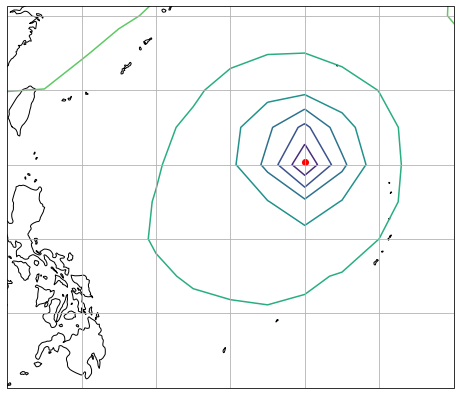

In [100]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.contour(slp.lon, slp.lat, slp, transform=ccrs.PlateCarree())
ax.scatter(lonmin, latmin, c="red", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.set_extent([120, 150, 5, 30])

In [255]:
plon = np.deg2rad(np.arange(0, 360, 2))
plat = np.deg2rad(np.arange(80, 90.1, 1))
PLON, PLAT = np.meshgrid(plon, plat)
PLON = PLON.flatten()
PLAT = PLAT.flatten()

In [256]:
X = np.cos(PLON) * np.cos(PLAT)
Y = np.sin(PLON) * np.cos(PLAT)
Z = np.sin(PLAT)

In [257]:
rlonmin, rlatmin = np.deg2rad(lonmin), np.deg2rad(latmin)
clon, slon = np.cos(rlonmin), np.sin(rlonmin)
clat, slat = np.cos(rlatmin), np.sin(rlatmin)
amat = np.array([[clon*slat, -slon, clon*clat],
                 [slon*slat,  clon, slon*clat],
                 [-clat,         0, slat]])

In [258]:
xyz = amat @ np.vstack([X, Y, Z])

In [259]:
tlon = np.rad2deg(np.arctan2(xyz[1, :], xyz[0, :]))
tlat = np.rad2deg(np.arcsin(xyz[2, :]))

In [179]:
yyyy = 2019
yyyymmdd = f"{yyyy}-10-09"
lat0, lat1 = 60, 0
lon0, lon1 = 110, 170
ds_T = xr.open_dataset(f"{dods}/air.{yyyy}.nc")
T = ds_T.air.loc[yyyymmdd, :, lat0:lat1, lon0:lon1]

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


二重線型内挿NCLのlinint2_pointsを実装する。

In [298]:
def closest_val(xval, x):
    i = np.argmin(np.abs(xval - x))
    if x[i] > xval:
        i -= 1
    return i

In [299]:
def linint2_points(xi, yi, fi, xo, yo):
    if xi[0] > xi[1]:
        print("xi must be ascending")
        return np.NaN
    if yi[0] > yi[1]:
        print("yi must be ascending")
        return np.NaN
    kmax = np.amin([xo.size, yo.size])
    fo = np.zeros(kmax)
    for k in range(kmax):
        i, j = closest_val(xo[k], xi), closest_val(yo[k], yi)
        t = (xo[k] - xi[i]) / (xi[i+1] - xi[i])
        u = (yo[k] - yi[j]) / (yi[j+1] - yi[j])
        fo[k] = (1-u) * ((1-t) * fi[j,i] + t * fi[j,i+1]) + \
                    u * (t * fi[j+1,i+1] + (1-t) * fi[j+1,i])
    return fo

In [300]:
TT = linint2_points(T.lon.data, T.lat.data[::-1], T[0, ::-1], tlon, tlat)

In [261]:
from scipy.interpolate import RegularGridInterpolator


T_rotated = np.zeros([T.level.size, tlon.size])
for k in range(T.shape[0]):
    print(T.level[k].data)
    func = RegularGridInterpolator([T.lat[::-1], T.lon], T[k,::-1])
    for i in range(tlon.size):
        T_rotated[k, i] = func([tlat[i], tlon[i]])

1000.0
850.0
700.0
500.0
400.0
300.0
250.0
200.0
150.0
100.0
70.0
50.0


In [262]:
T_rotated = T_rotated.reshape(T.level.size, plat.size, plon.size)

In [263]:
T_rotated_symmetric = T_rotated.mean(axis=2)

In [264]:
T_rotated_symmetric.shape

(12, 11)

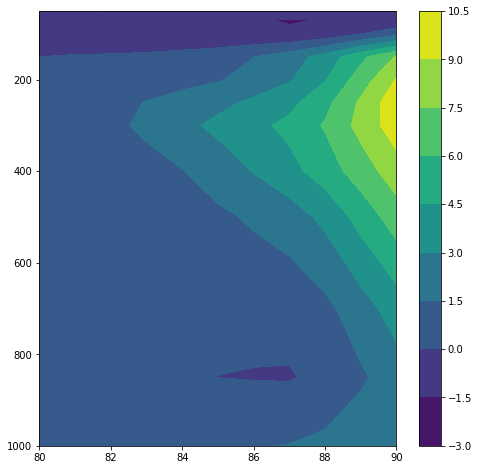

In [265]:
fig, ax = plt.subplots(figsize=[8, 8])
p = ax.contourf(np.rad2deg(plat), T.level, T_rotated_symmetric-T_rotated_symmetric[:,0][:, None])
ax.invert_yaxis()
fig.colorbar(p)
plt.show()